In [1]:
import numpy as np
import cv2
import os
import sys
import torch
import torchvision
import tensorflow as tf
from tensorflow.keras import layers
from torchvision import transforms

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

class CameraPoseVisualizer:
    def __init__(self, xlim, ylim, zlim):
        self.fig = plt.figure(figsize=(18, 7))
        self.ax = self.fig.gca(projection='3d')
        self.ax.set_aspect("auto")
        self.ax.set_xlim(xlim)
        self.ax.set_ylim(ylim)
        self.ax.set_zlim(zlim)
        self.ax.set_xlabel('x')
        self.ax.set_ylabel('y')
        self.ax.set_zlabel('z')
        print('initialize camera pose visualizer')

    def extrinsic2pyramid(self, extrinsic, color='r', focal_len_scaled=5, aspect_ratio=0.3):
        vertex_std = np.array([[0, 0, 0, 1],
                               [focal_len_scaled * aspect_ratio, -focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [focal_len_scaled * aspect_ratio, focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [-focal_len_scaled * aspect_ratio, focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [-focal_len_scaled * aspect_ratio, -focal_len_scaled * aspect_ratio, focal_len_scaled, 1]])
        vertex_transformed = vertex_std @ extrinsic.T
        meshes = [[vertex_transformed[0, :-1], vertex_transformed[1][:-1], vertex_transformed[2, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[4, :-1], vertex_transformed[1, :-1]],
                            [vertex_transformed[1, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]]]
        self.ax.add_collection3d(
            Poly3DCollection(meshes, facecolors=color, linewidths=0.3, edgecolors=color, alpha=0.35))

    def customize_legend(self, list_label):
        list_handle = []
        for idx, label in enumerate(list_label):
            color = plt.cm.rainbow(idx / len(list_label))
            patch = Patch(color=color, label=label)
            list_handle.append(patch)
        plt.legend(loc='right', bbox_to_anchor=(1.8, 0.5), handles=list_handle)

    def colorbar(self, max_frame_length):
        cmap = mpl.cm.rainbow
        norm = mpl.colors.Normalize(vmin=0, vmax=max_frame_length)
        self.fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label='Frame Number')

    def show(self):
        plt.title('Extrinsic Parameters')
        plt.show()

initialize camera pose visualizer


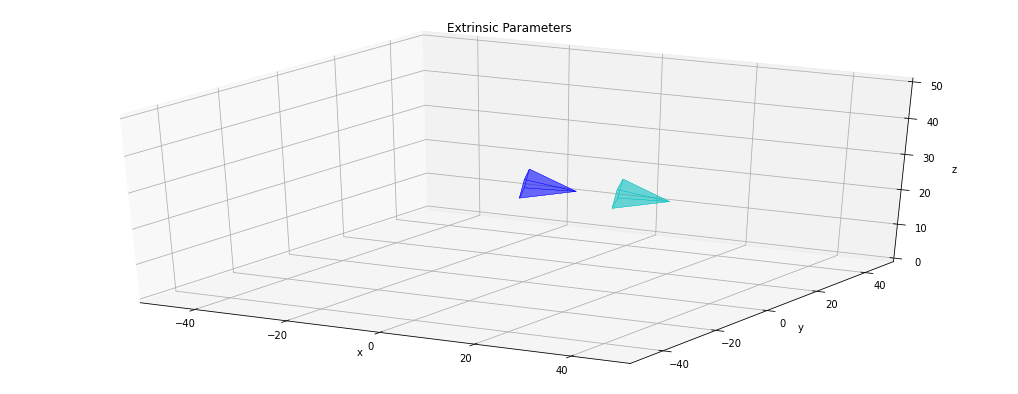

In [7]:
pose_left = np.array([
                [ 0.4865719, -0.2211690, -0.8451817, 20],
                [-0.5292259,  0.6951027, -0.4865719, 20],
                [ 0.6951027,  0.6840442,  0.2211690, 20],
                [0, 0, 0, 1],
])

pose_right = np.array([
                [ 0.4865719, -0.2211690, -0.8451817, 0],
                [-0.5292259,  0.6951027, -0.4865719, 20],
                [ 0.6951027,  0.6840442,  0.2211690, 20],
                [0, 0, 0, 1],
])
# argument : the minimum/maximum value of x, y, z
visualizer = CameraPoseVisualizer([-50, 50], [-50, 50], [0, 50])

# argument : extrinsic matrix, color, scaled focal length(z-axis length of frame body of camera
visualizer.extrinsic2pyramid(pose_left, 'c', 10)
visualizer.extrinsic2pyramid(pose_right, 'b', 10)

visualizer.show()

initialize camera pose visualizer


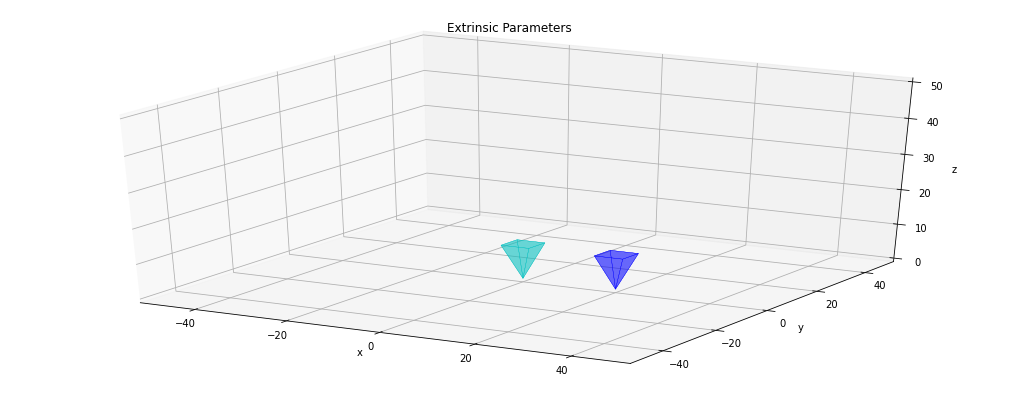

In [9]:
pose_left = np.eye(4)

pose_right = np.array([
                [ 1, 0, 0, 20],
                [ 0, 1, 0, 0 ],
                [ 0, 0, 1, 0 ],
                [ 0, 0, 0, 1 ],
])
# argument : the minimum/maximum value of x, y, z
visualizer = CameraPoseVisualizer([-50, 50], [-50, 50], [0, 50])

# argument : extrinsic matrix, color, scaled focal length(z-axis length of frame body of camera
visualizer.extrinsic2pyramid(pose_left, 'c', 10)
visualizer.extrinsic2pyramid(pose_right, 'b', 10)

visualizer.show()

In [16]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Using ', device)

Using  cpu


In [162]:
left_rotation = torch.tensor(((245.0, 234.0, 65.0)))[None].to(device)
left_translation = torch.tensor(((20.0, 10.0, 10.0)))[None].to(device)

In [163]:
right_rotation = torch.tensor(((245.0, 234.0, 65.0)))[None].to(device)
right_translation = torch.tensor(((0.0,10.0, 10.0)))[None].to(device)

In [164]:
def euler_to_rotation(angle: torch.tensor):
    batch_size = angle.shape[0]
    
    zeros = torch.zeros(batch_size, 1)
    ones = torch.ones(batch_size, 1)    

    x, y, z = angle[:, 0], angle[:, 1], angle[:, 2]

    x_cos = torch.cos(x)
    x_sin = torch.sin(x)

    x = torch.tensor([
        [
            ones, zeros, zeros, 
            zeros, x_cos, -x_sin,
            zeros, x_sin, x_cos
        ]
    ]).reshape(batch_size, 3, 3)

    y_cos = torch.cos(y)
    y_sin = torch.sin(y)

    y = torch.tensor([
        [ 
            y_cos, zeros, y_sin,
            zeros, ones , zeros,
            -y_sin, zeros, y_cos
        ]
    ]).reshape(batch_size, 3, 3)
    
    z_cos = torch.cos(z)
    z_sin = torch.sin(z)

    z = torch.tensor([
        [
            z_cos, -z_sin, zeros,
            z_sin, z_cos, zeros,
            zeros, zeros, ones
        ],
    ]).reshape(batch_size, 3, 3)
    
    return torch.bmm(torch.bmm(x, y), z)

In [165]:
def construct_transformation_matrix(angle, translation_matrix):
    """
        Construct transformation matrix given angle matrix(B, 3) and translation matrix(B, 3)
        angle: Bx3
        translation_matrix: Bx3
        transformation matrix : Bx4x4
    """
    batch_size = angle.shape[0]
    assert angle.shape[0] == translation_matrix.shape[0]
    rotation_matrix = euler_to_rotation(angle) # Bx3x3
    print(rotation_matrix)
    assert rotation_matrix.shape[0] == translation_matrix.shape[0]
    
    translation_matrix = translation_matrix.unsqueeze(dim=2) # Bx3x1
    transformation_matrix = torch.cat((rotation_matrix, translation_matrix), dim=2) # Bx3x4

    identity = torch.tensor([0, 0, 0, 1]).to(translation_matrix.device) # 4
    identity = identity.repeat(batch_size, 1, 1) # Bx1x4

    transformation_matrix = torch.cat((transformation_matrix, identity), dim=1) # Bx4x4

    return transformation_matrix

In [166]:
left_transformation_matrix = construct_transformation_matrix(left_rotation, left_translation)
right_transformation_matrix = construct_transformation_matrix(right_rotation, right_translation)

tensor([[[-0.0274, -0.0402,  0.9988],
         [ 0.8509, -0.5254,  0.0022],
         [ 0.5247,  0.8499,  0.0486]]])
tensor([[[-0.0274, -0.0402,  0.9988],
         [ 0.8509, -0.5254,  0.0022],
         [ 0.5247,  0.8499,  0.0486]]])


In [ ]:
!pip install transforms3d

In [167]:
import transforms3d.euler as eul
eul.euler2mat(245, 234, 65, axes='sxyz')

array([[-0.0273541 , -0.80118206, -0.59779516],
       [ 0.04021157, -0.59841681,  0.8001752 ],
       [-0.99881669, -0.00215021,  0.04858594]])

In [168]:
left_transformation_matrix = np.array(left_transformation_matrix[0])
right_transformation_matrix = np.array(right_transformation_matrix[0])

initialize camera pose visualizer


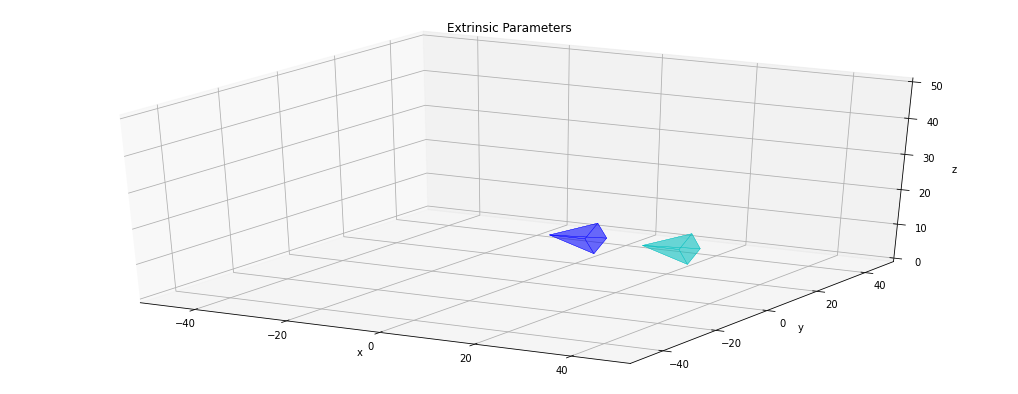

In [169]:
pose_left = left_transformation_matrix
pose_right = right_transformation_matrix

# argument : the minimum/maximum value of x, y, z
visualizer = CameraPoseVisualizer([-50, 50], [-50, 50], [0, 50])

# argument : extrinsic matrix, color, scaled focal length(z-axis length of frame body of camera
visualizer.extrinsic2pyramid(pose_left, 'c', 10)
visualizer.extrinsic2pyramid(pose_right, 'b', 10)

visualizer.show()

In [170]:
loss = torch.nn.L1Loss()(left_translation, right_translation) + torch.nn.L1Loss()(left_rotation, right_rotation)
print(loss)

tensor(6.6667)
